**Parameterization of Temperature and Salinity with depth**

In [1]:
from netCDF4 import *
import numpy as np
from scipy import interpolate
import scipy.io
import matplotlib.pyplot as plt
import paramTSz as func
import stericheight as sth
import geopy.distance
from sympy.solvers.solveset import linsolve
import julian
import datetime
from math import *
%matplotlib inline

ds = Dataset('EN.4.2.1.f.profiles.g10.201901.nc')
# for i in ds.variables:
#     print(ds.variables[i])
    
# temperature (in degC)
T = ds.variables['TEMP'][:]

# practical salinity
PSAL = ds.variables['PSAL_CORRECTED'][:]

# depth
depth = ds.variables['DEPH_CORRECTED'][:]

# julian day of the profile (JULD:units = "days since 1950-01-01 00:00:00 UTC")
t = ds.variables['JULD'][:]
date_ref = datetime.datetime.strptime('1950-01-01 00:00:00', "%Y-%m-%d %H:%M:%S")
jd_ref = julian.to_jd(date_ref, fmt='jd')
time = np.array([julian.from_jd(t[i] + jd_ref) for i in range(len(t))])
    
lat = ds.variables['LATITUDE'][:]
long = ds.variables['LONGITUDE'][:]

Functions to interpolate gridded T,S at given locations

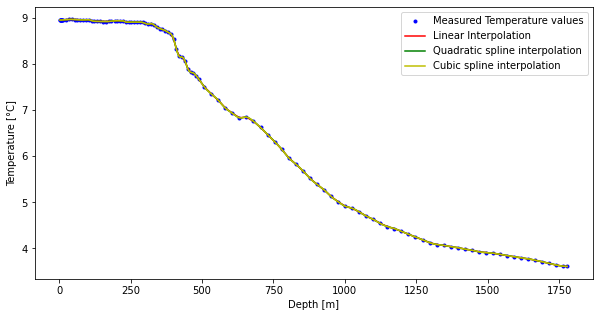

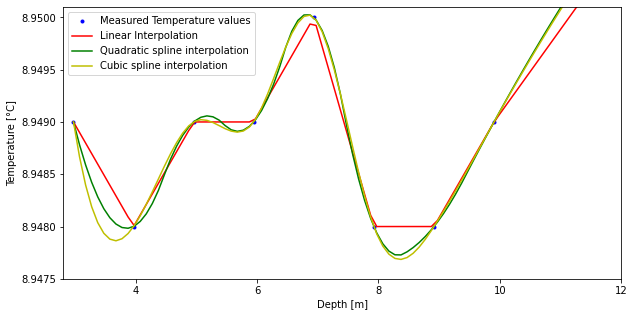

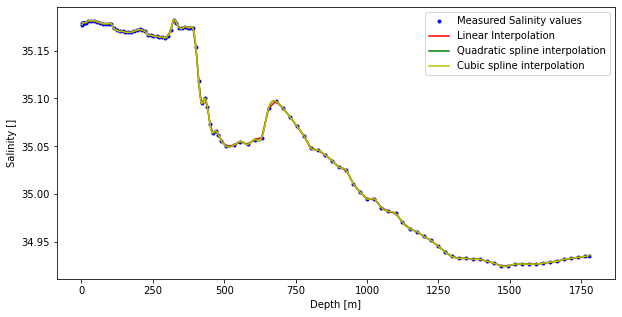

In [2]:
# remove masked values
T_new = T[0,:][~T[0,:].mask]
PSAL_new = PSAL[0,:][~PSAL[0,:].mask]
depth_new = depth[0,:][~depth[0,:].mask]

x = depth_new

# interpolate T,S at given locations
f_T, x_new = func.interpolateTS(x, T_new, "linear")
f2_T, x_new = func.interpolateTS(x, T_new, "quadratic")
f3_T, x_new = func.interpolateTS(x, T_new, "cubic")

f_PSAL, x_new = func.interpolateTS(x, PSAL_new, "linear")
f2_PSAL, x_new = func.interpolateTS(x, PSAL_new, "quadratic")
f3_PSAL, x_new = func.interpolateTS(x, PSAL_new, "cubic")

plt.figure(figsize=(10,5))
plt.plot(x,T_new,'b.',x_new,f_T(x_new), 'r-')
plt.plot(x_new,f2_T(x_new), 'g-')
plt.plot(x_new,f3_T(x_new), 'y-')
plt.xlabel("Depth [m]")
plt.ylabel("Temperature [°C]")
plt.legend(["Measured Temperature values","Linear Interpolation", "Quadratic spline interpolation", "Cubic spline interpolation"])
plt.show()

plt.figure(figsize=(10,5))
plt.xlim([2.8,12.])
plt.ylim([8.9475,8.9501])
plt.plot(x,T_new,'b.', x_new, f_T(x_new), 'r-')
plt.plot(x_new, f2_T(x_new), 'g-')
plt.plot(x_new, f3_T(x_new), 'y-')
plt.xlabel("Depth [m]")
plt.ylabel("Temperature [°C]")
plt.legend(["Measured Temperature values","Linear Interpolation", "Quadratic spline interpolation", "Cubic spline interpolation"])
plt.show()

plt.figure(figsize=(10,5))
plt.plot(x,PSAL_new,'b.',x_new,f_PSAL(x_new), 'r-')
plt.plot(x_new,f2_PSAL(x_new), 'g-')
plt.plot(x_new,f3_PSAL(x_new), 'y-')
plt.xlabel("Depth [m]")
plt.ylabel("Salinity []")
plt.legend(["Measured Salinity values","Linear Interpolation", "Quadratic spline interpolation", "Cubic spline interpolation"])
plt.show()

Plots of T vs. depth, S vs. depth and T vs. S

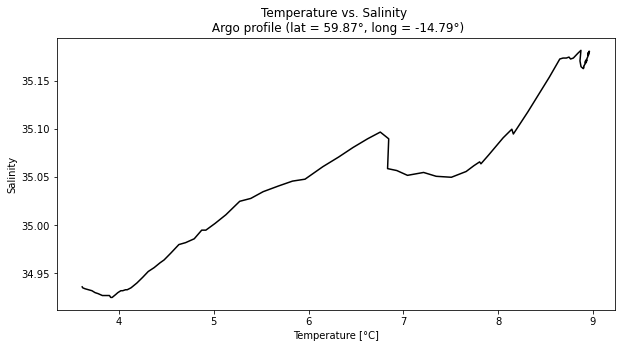

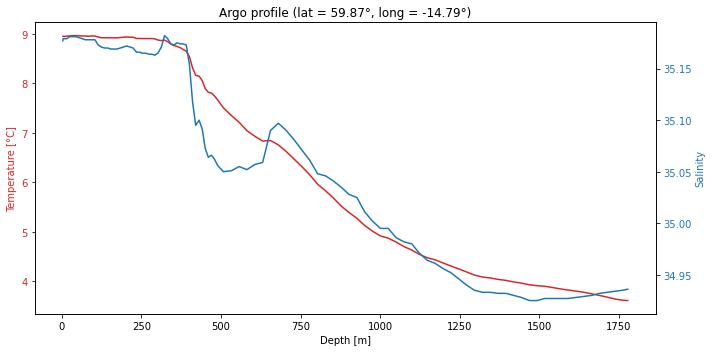

In [3]:
plt.figure(figsize=(10,5))
plt.plot(T[0,:], PSAL[0,:],'k')
plt.xlabel("Temperature [°C]")
plt.ylabel("Salinity")
plt.title('Temperature vs. Salinity \n Argo profile (lat = '+str(round(lat[0],2))+'°'+', long = '+str(round(long[0],2))+'°)')
plt.show()

func.plotDepthST(T[0,:], PSAL[0,:], depth[0,:], lat[0], long[0])

**Interpolate T,S at the bottom pressure locations**

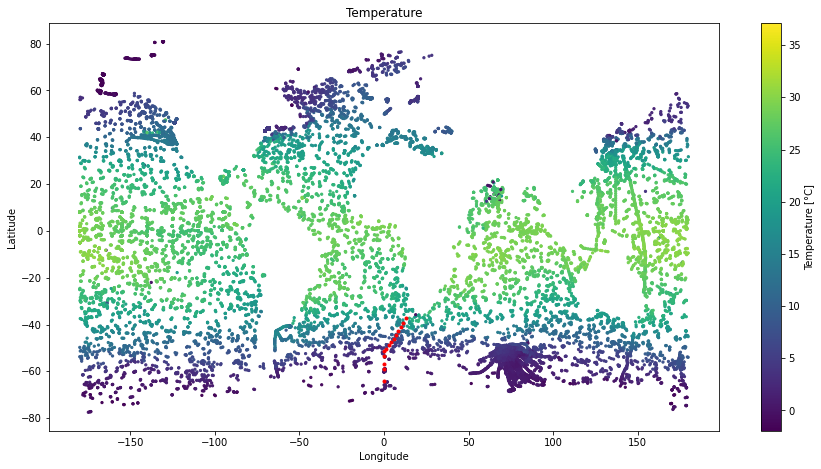

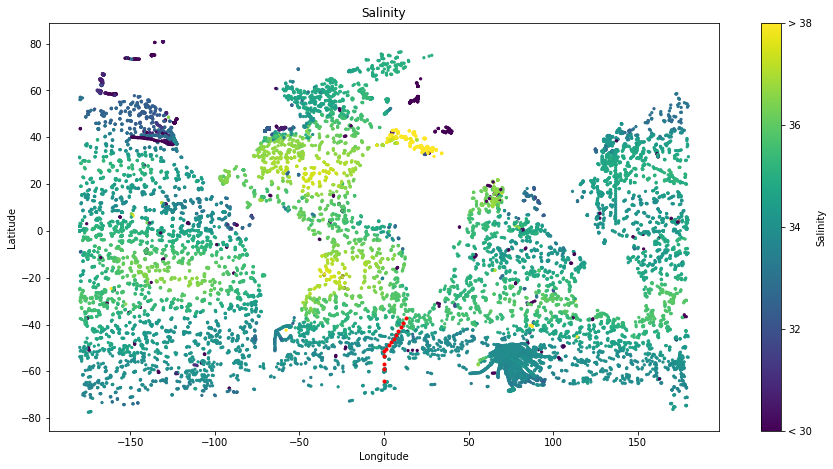

In [4]:
# read bottom pressure data (https://github.com/strawpants/schroeter-southatlantic-2019/tree/master/analysis/data)
data = scipy.io.loadmat('OBPv2.mat')
degE = data['degE'] 
degN = data['degN'] 
P_oc = data['OPRES']
time = data['OTIME']

marker_size=5
plt.figure(figsize=(15,7.5))
plt.scatter(long, lat, marker_size, c=T[:,0])
plt.plot(degE, degN, 'r.')
plt.title("Temperature")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
cbar= plt.colorbar()
cbar.set_label("Temperature [°C]")
plt.show()

plt.figure(figsize=(15,7.5))
plt.scatter(long, lat, marker_size, c=PSAL[:,0])
plt.plot(degE, degN, 'r.')
plt.title("Salinity")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
cbar= plt.colorbar(ticks=[30, 32, 34, 36, 38])
plt.clim(30,38)
cbar.ax.set_yticklabels(['< 30', '32', '34','36','> 38'])
cbar.set_label("Salinity")
plt.show()

In [5]:
# Merge most similar Temperature/Salinity measurements in a cluster
# plt.figure(figsize=(10,5))
# plt.ylim([-70,-30])
# plt.xlim([-15,30])
# plt.plot(long, lat, '.')
# for i in range(len(degE)):
#     idx_T, cluster_T, lat_cluster_T, long_cluster_T = func.clustering(lat, long, degN[i], degE[i], T[:,0], 3) # Temperature
#     idx_S, cluster_S, lat_cluster_S, long_cluster_S = func.clustering(lat, long, degN[i], degE[i], PSAL[:,0], 1) # Salinity
#     plt.plot(long_cluster_T, lat_cluster_T, '.')
#     globals()["T_all_cluster_" + str(i)] = np.array(T[list(idx_T.astype(int)),:]) # Temperature
#     globals()["T_depth_cluster_" + str(i)] = np.array(depth[list(idx_T.astype(int)),:])
    
#     globals()["S_all_cluster_" + str(i)] = np.array(PSAL[list(idx_S.astype(int)),:]) # Salinity
#     globals()["S_depth_cluster_" + str(i)] = np.array(depth[list(idx_S.astype(int)),:])
# plt.plot(degE, degN, 'k.')
# plt.xlabel("Longitude")
# plt.ylabel("Latitude")      
# plt.show()

In [6]:
# def clustering2(lat, long, degN, degE, obs, depth):
#     x = np.where((long < (degE+4)) & (long > (degE-4)) & (lat < (degN+3)) & (lat > (degN-3)))
#     mean_obs = [np.mean(t) for t in obs[x,:][0]] # mean of each profile
#     std_obs = np.std(mean_obs)
#     idx = np.where(mean_obs-np.median(mean_obs) < std_obs)
#     obs_cluster = obs[x[0][idx],:]
#     depth_cluster = depth[x[0][idx],:]
#     return x, idx, obs_cluster, depth_cluster

Tmodel = Dataset('woa18_decav_t01_01.nc') # January
  
lat_model = Tmodel.variables['lat'][:]
long_model = Tmodel.variables['lon'][:]
zlevels = Tmodel.variables['depth'][:]
t_an = Tmodel.variables['t_an'][:] # Objectively analyzed mean fields for sea_water_temperature at standard depth levels
t_mn = Tmodel.variables['t_mn'][:] # Average of all unflagged interpolated values at each standard depth level for
                                 # sea_water_temperature in each grid-square which contain at least one measurement.

def clustering2(lat, long, degN, degE, obs, depth, maxdiff, lat_model, long_model, obs_type, t_m, zlevels):
    prof_mean = np.array([])
    x = np.where((long < (degE+4)) & (long > (degE-4)) & (lat < (degN+3)) & (lat > (degN-3)))
    profiles = []
    for ID in x[0]:
        profile = obs[int(ID),:]
        z = depth[int(ID),:]
        lat_prof = lat[int(ID)]
        long_prof = long[int(ID)]
        
        if obs_type == 'T':
            diff_pos = [np.argmin(abs(lat_prof-lat_model)), np.argmin(abs(long_prof-long_model))]
            t_model = t_m[:,:,diff_pos[0], diff_pos[1]]
            t_model = t_model[np.where(t_model < 100)] # remove masked values
            zlev = zlevels[np.where(t_model < 100)]
            
            if t_model.size > 0:
                f_model, x_model = func.interpolateTS(zlev, t_model, "quadratic") # interpolate model

            list_ind = np.zeros((profile.size))
            for i in range(z.size):
                diff = z[i] - x_model
                ind_min = np.argmin(abs(diff))
                list_ind[i] = ind_min
            deltaT = profile - f_model(x_model)[list_ind.astype(int)] # T - T0
            profile = deltaT
        profiles.append(profile)
        
        kappa = np.array((0, 100, 150, 200, 1000, np.max(z)))
        dkappa = 2000 
        A = func.getA(kappa, dkappa, z) # get designmatrix
        xS,lS,v,rp = func.linearGMM(A, profile)

        #-------------------------- Evaluation of the function on an equidistant grid
        t_Raster = np.arange(np.min(z), np.max(z), (np.max(z)-np.min(z))/10000) # vector with equidistant values
        Ax = func.getA(kappa, dkappa, t_Raster)
        f_Raster = Ax.dot(xS)
        
        prof_mean = np.append(prof_mean, np.mean(f_Raster))
    cluster_mean = np.mean(prof_mean)
    diff = cluster_mean - prof_mean
    
    x_new = np.copy(x[0])
    while np.max(np.abs(diff)) > maxdiff:
        idx = np.argmax(np.abs(diff))
        prof_mean = np.delete(prof_mean, idx)
        x_new = np.delete(x_new, idx)
        cluster_mean = np.mean(prof_mean)
        diff = cluster_mean - prof_mean

    if obs_type == 'T':
        Delta = np.zeros((x_new.size, len(profiles[0])))
        for y in range(len(x_new)):
            #obs_cluster.append(np.asarray(profiles)[np.where(np.equal(x[0], x_new[y]))])
            Delta[y] = np.asarray(profiles)[np.where(np.equal(x[0], x_new[y]))]
    else:
        Delta = 0
    obs_cluster = obs[x_new,:]
    depth_cluster = depth[x_new,:]
    return x, x_new, obs_cluster, depth_cluster, Delta
        
diff_S = np.array((0.05, 0.03, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01))
for j in range(len(degN)):
    x_temp, idx_temp, T_cluster, d_cluster_T, Delta_T = clustering2(lat, long, degN[j], degE[j], T, depth, 0.1, lat_model,
                                                           long_model, 'T', t_mn, zlevels)
    x_sal, idx_sal, S_cluster, d_cluster_S, Delta_S = clustering2(lat, long, degN[j], degE[j], PSAL, depth, diff_S[j], lat_model,
                                                         long_model, 'S', t_mn, zlevels)
    globals()["T_all_cluster_" + str(j)] = T_cluster # Temperature
    globals()["T_depth_cluster_" + str(j)] = d_cluster_T
    globals()["Delta_T_" + str(j)] = Delta_T
    globals()["S_all_cluster_" + str(j)] = S_cluster # Salinity
    globals()["S_depth_cluster_" + str(j)] = d_cluster_S
    
#     print('#profiles: ', len(T_cluster))
#     plt.figure(figsize=(10,2))
#     plt.plot(d_cluster_T, T_cluster, '.')
#     plt.show()

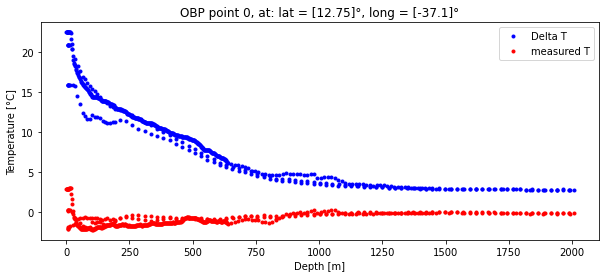

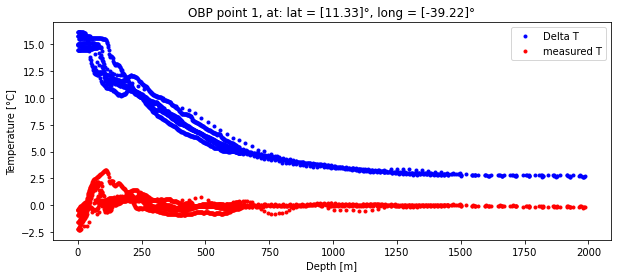

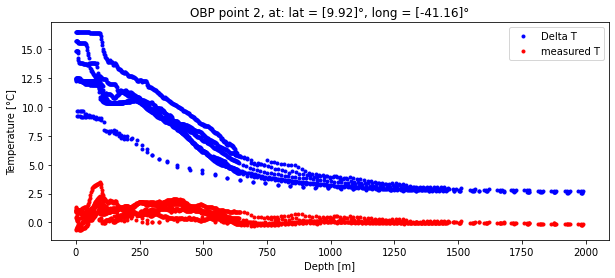

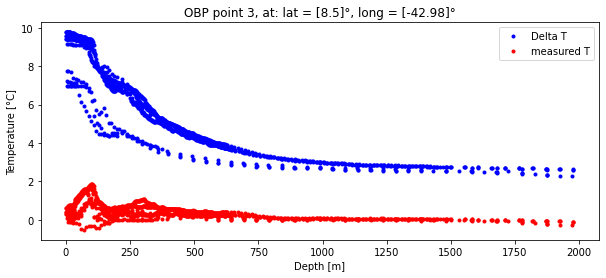

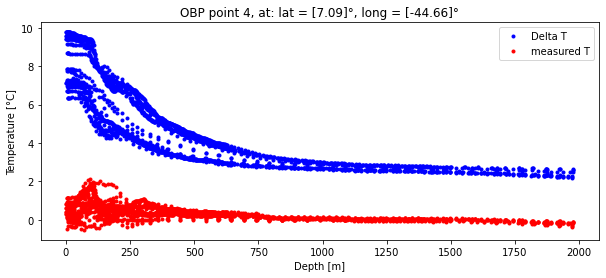

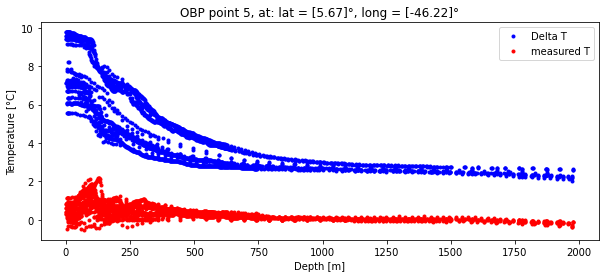

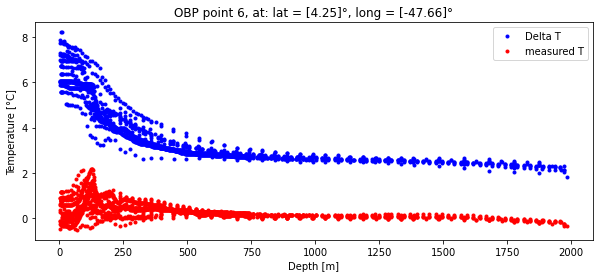

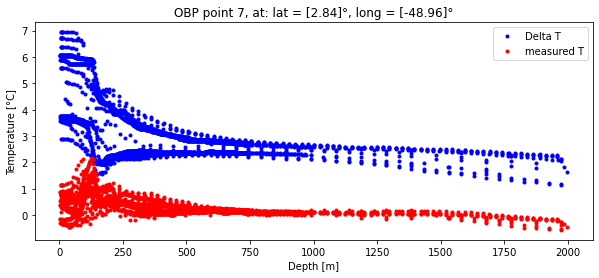

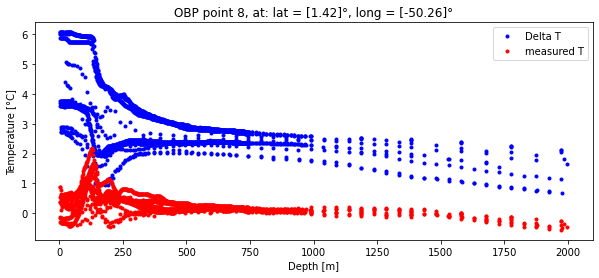

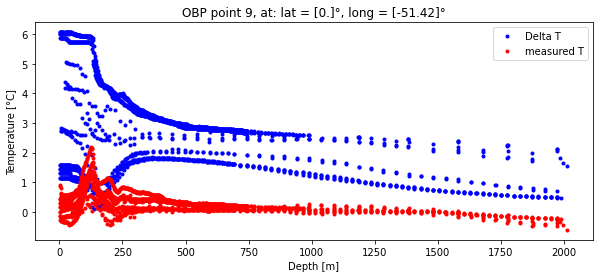

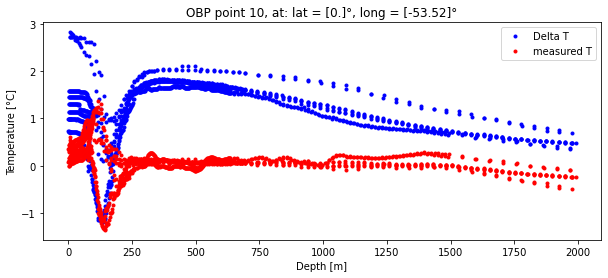

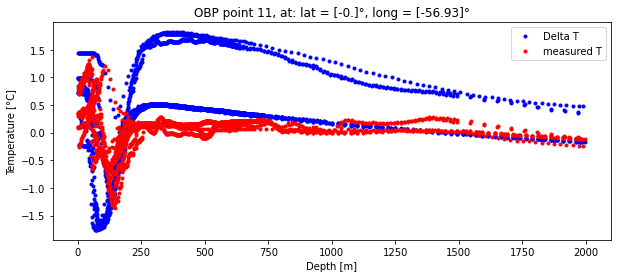

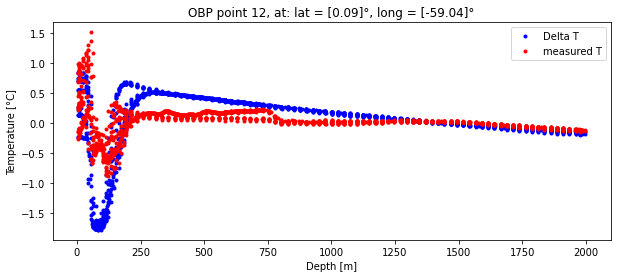

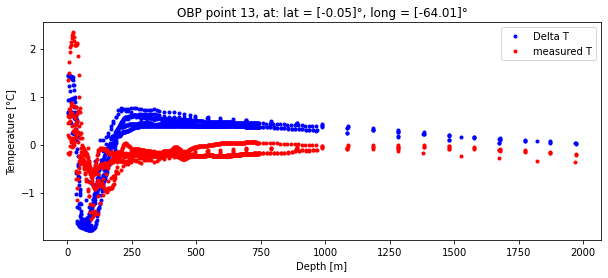

In [7]:
for j in range(len(degN)):
    
    T_depth_cluster = globals()["T_depth_cluster_" + str(j)] 
    T_cluster = globals()["T_all_cluster_" + str(j)]
    DeltaT = globals()["Delta_T_" + str(j)]
    
    plt.figure(figsize=(10,4))
    plt.title('OBP point '+str(j)+', at: lat = '+str(np.round(degE[j],2))+'°'+', long = '+str(np.round(degN[j],2))+'°')
    plt.plot(T_depth_cluster.ravel(), T_cluster.ravel(),'b.', T_depth_cluster.ravel(), DeltaT.ravel(), 'r.')
    plt.legend(['Delta T', 'measured T'])
    plt.xlabel("Depth [m]")
    plt.ylabel("Temperature [°C]")
    plt.show()

Cluster 0 , # parameters (T) =  (9,)
Cluster 0 , # parameters (S) =  (9,)


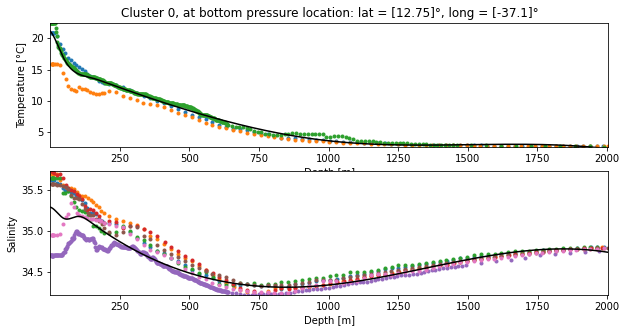

Cluster 1 , # parameters (T) =  (9,)
Cluster 1 , # parameters (S) =  (9,)


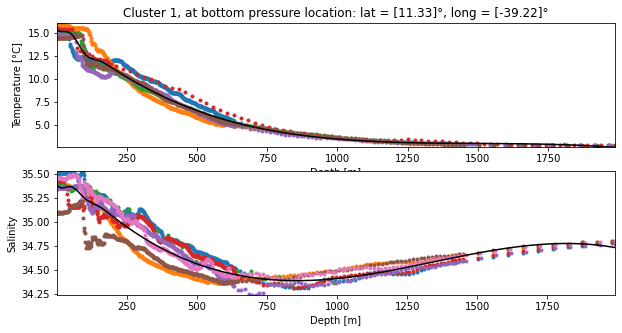

Cluster 2 , # parameters (T) =  (9,)
Cluster 2 , # parameters (S) =  (9,)


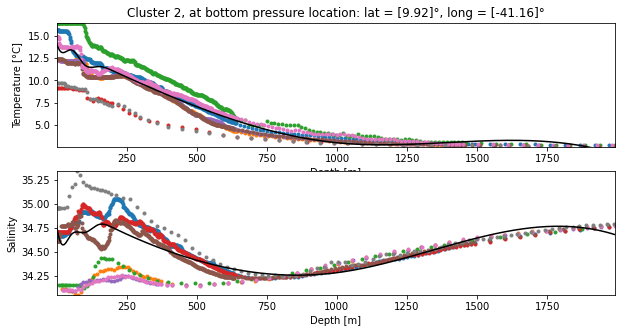

Cluster 3 , # parameters (T) =  (9,)
Cluster 3 , # parameters (S) =  (9,)


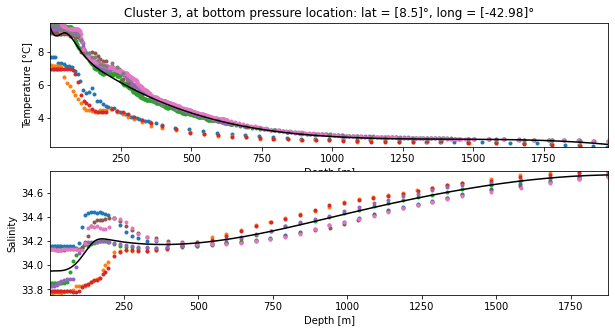

Cluster 4 , # parameters (T) =  (9,)
Cluster 4 , # parameters (S) =  (9,)


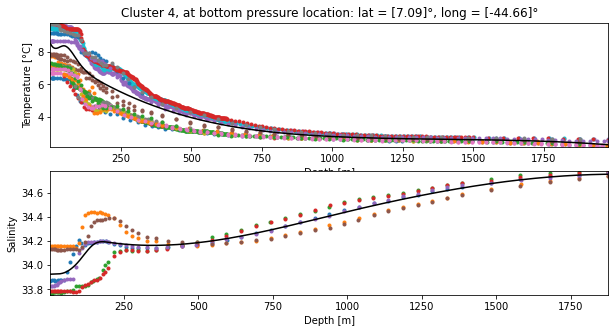

Cluster 5 , # parameters (T) =  (9,)
Cluster 5 , # parameters (S) =  (9,)


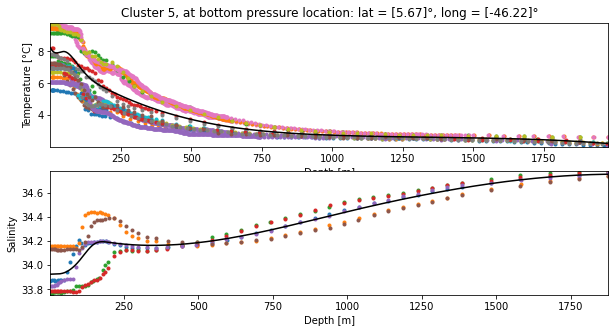

Cluster 6 , # parameters (T) =  (9,)
Cluster 6 , # parameters (S) =  (9,)


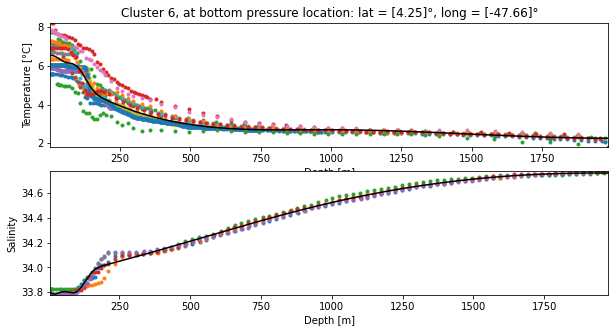

Cluster 7 , # parameters (T) =  (9,)
Cluster 7 , # parameters (S) =  (9,)


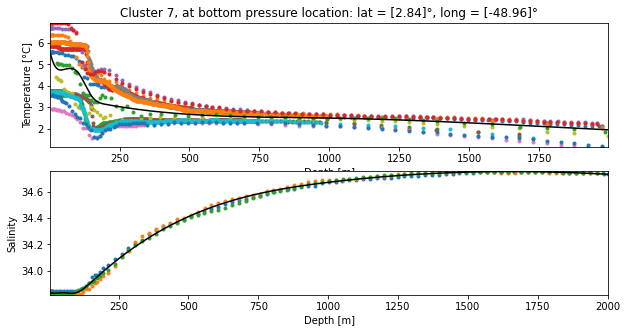

Cluster 8 , # parameters (T) =  (9,)
Cluster 8 , # parameters (S) =  (9,)


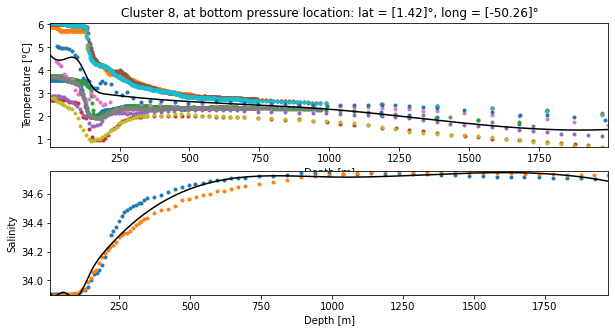

Cluster 9 , # parameters (T) =  (9,)
Cluster 9 , # parameters (S) =  (9,)


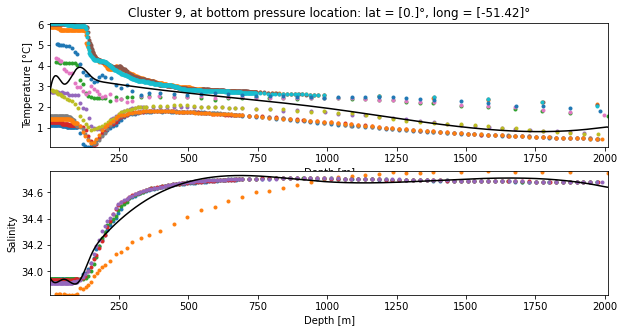

Cluster 10 , # parameters (T) =  (9,)
Cluster 10 , # parameters (S) =  (9,)


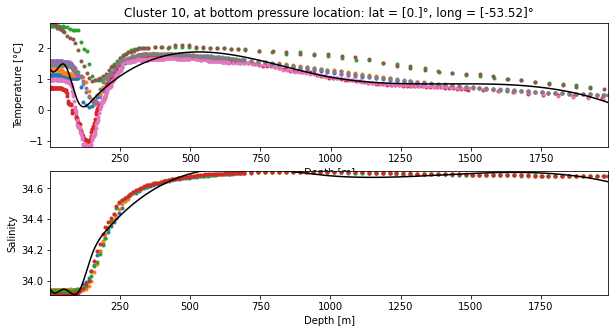

Cluster 11 , # parameters (T) =  (9,)
Cluster 11 , # parameters (S) =  (9,)


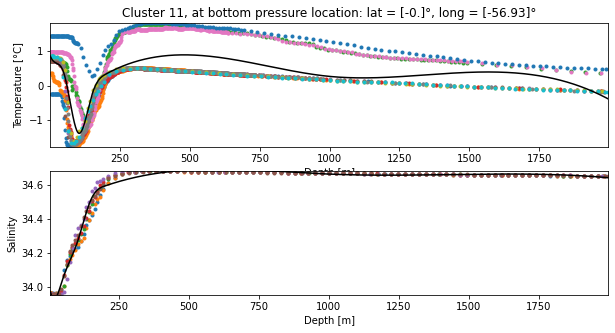

Cluster 12 , # parameters (T) =  (9,)
Cluster 12 , # parameters (S) =  (9,)


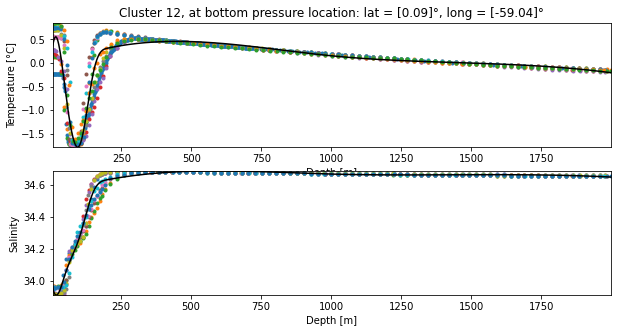

Cluster 13 , # parameters (T) =  (9,)
Cluster 13 , # parameters (S) =  (9,)


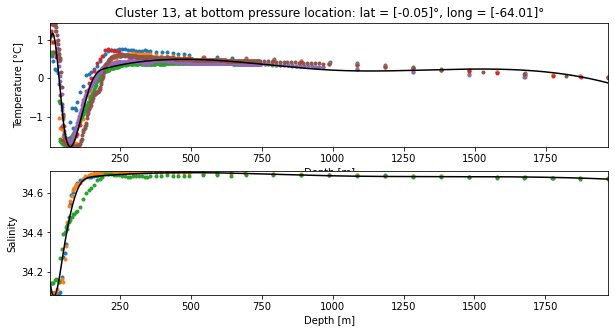

In [8]:
# Approximation of T,S at the bottom pressure locations => cubic b-splines
rms_S = []
rms_T = []
for j in range(len(degE)):
    # get all T/S and z values belonging to a cluster
    T_depth_cluster = globals()["T_depth_cluster_" + str(j)] 
    T_cluster = globals()["T_all_cluster_" + str(j)]
    
    S_depth_cluster = globals()["S_depth_cluster_" + str(j)]
    S_cluster = globals()["S_all_cluster_" + str(j)]
    
    # reshape matrices in a vector
    T_new = T_cluster.ravel()
    T_depth_new = T_depth_cluster.ravel()
    S_new = S_cluster.ravel()
    S_depth_new = S_depth_cluster.ravel()
    
    T_new_ = T_new[T_new < 100]
    T_depth_new = T_depth_new[np.where(T_new < 100)]
    T_new = T_new_
    S_new = S_new[~S_new.mask]
    S_depth_new = S_depth_new[~S_depth_new.mask]
    
#     T_depth_new = T_depth_new[T_depth_new != 99999] # delete masked values (=999999)
#     T_new = T_new[T_new != 99999]
#     S_depth_new = S_depth_new[S_depth_new != 99999]
#     S_new = S_new[S_new != 99999]
    
    S_depth_sort = np.sort(S_depth_new) # sort the depth values
    T_depth_sort = np.sort(T_depth_new)
    S_new_ = S_new[np.argsort(S_depth_new)] # sort T/S in corresponding order
    T_new_ = T_new[np.argsort(T_depth_new)]
    
    #-----------------------------equidistant points
    # node distance
#     dkappa_T = 400
#     dkappa_S = 400
#     dkappa_T = ceil(np.max(T_depth_new)/5)
#     dkappa_S = ceil(np.max(S_depth_new)/5)

#     # nodes
#     kappa_x_T = np.arange(0, ceil(np.max(T_depth_new)/dkappa_T)*dkappa_T + dkappa_T, dkappa_T)
#     kappa_x_S = np.arange(0, ceil(np.max(S_depth_new)/dkappa_S)*dkappa_S + dkappa_S, dkappa_S)
    #-------------------------------
    
    #-------------------------------distance depending on T/S gradient
    kappa_x_T = np.array((0, 50, 100, 150, 200, 1000, np.max(T_depth_sort)))
    dkappa_T = 2000 
    
    kappa_x_S = np.array((0, 50, 100, 150, 200, 1000, np.max(S_depth_sort)))
    dkappa_S = 2000 

    #-------------------------------
    
    # get designmatrices
    A_T = func.getA(kappa_x_T, dkappa_T, T_depth_sort)
    A_S = func.getA(kappa_x_S, dkappa_S, S_depth_sort)
    
    xS_T,lS_T,v_T,rp_T = func.linearGMM(A_T, T_new_)
    xS_S,lS_S,v_S,rp_S = func.linearGMM(A_S, S_new_)
    
    rms_S.append(np.sqrt(np.mean(np.square(v_S))))
    rms_T.append(np.sqrt(np.mean(np.square(v_T))))
    
    #-------------------------- Evaluation of the functions on an equidistant grid
    t_Raster_S = np.arange(np.min(S_depth_sort), np.max(S_depth_sort), (np.max(S_depth_sort)-np.min(S_depth_sort))/10000) # vector with equidistant values
    t_Raster_T = np.arange(np.min(T_depth_sort), np.max(T_depth_sort), (np.max(T_depth_sort)-np.min(T_depth_sort))/10000)
    
    Ax_S = func.getA(kappa_x_S, dkappa_S, t_Raster_S)
    Ax_T = func.getA(kappa_x_T, dkappa_T, t_Raster_T)

    f_Raster_S = Ax_S.dot(xS_S)
    f_Raster_T = Ax_T.dot(xS_T)
    #--------------------------
    
    cluster = plt.figure(figsize=(10,5))
    plt.subplot(211)
    print("Cluster", str(j), ", # parameters (T) = ", xS_T.shape)
    plt.title('Cluster '+str(j)+', at bottom pressure location: lat = '+str(np.round(degE[j],2))+'°'+', long = '+str(np.round(degN[j],2))+'°')
    for i in range(len(T_depth_cluster)):
        plt.plot(T_depth_cluster[i,:], T_cluster[i,:], '.')
        plt.xlim([np.min(T_depth_cluster), np.max(T_depth_cluster[T_depth_cluster != 99999])])
        plt.ylim([np.min(T_cluster), np.max(T_cluster[T_cluster != 99999])])
        plt.xlabel("Depth [m]")
        plt.ylabel("Temperature [°C]")
    plt.plot(t_Raster_T, f_Raster_T, 'k')
    
    plt.subplot(212)
    print("Cluster", str(j), ", # parameters (S) = ", xS_S.shape)
    for i in range(len(S_depth_cluster)):
        plt.plot(S_depth_cluster[i,:], S_cluster[i,:], '.')
        plt.xlim([np.min(S_depth_cluster), np.max(S_depth_cluster[S_depth_cluster != 99999])])
        plt.ylim([np.min(S_cluster[S_cluster >= 30]), np.max(S_cluster[S_cluster != 99999])])
        plt.xlabel("Depth [m]")
        plt.ylabel("Salinity")
    plt.plot(t_Raster_S, f_Raster_S, 'k')
    plt.show()
    #cluster.savefig('cluster'+str(j)+'.png', bbox_inches='tight')
    

Apply fitting procedure to Argo profiles in vicinity

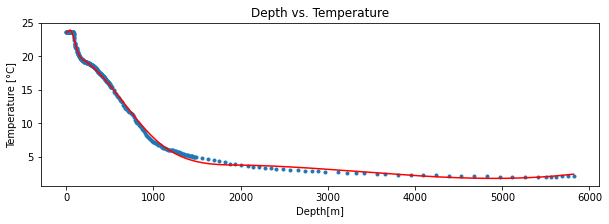

Max. depth = 5817.643 [m] # parameters: 10


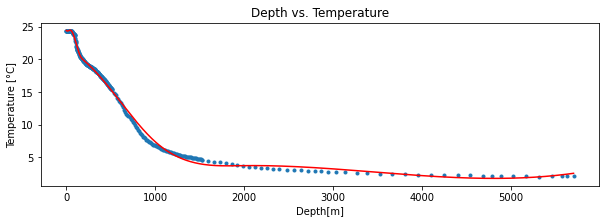

Max. depth = 5705.445 [m] # parameters: 10


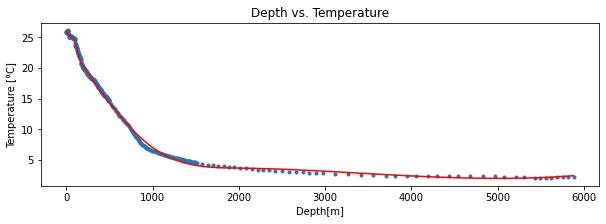

Max. depth = 5880.489 [m] # parameters: 10


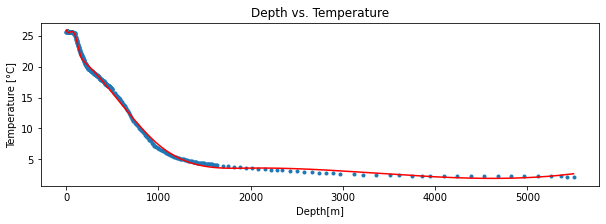

Max. depth = 5501.1924 [m] # parameters: 10


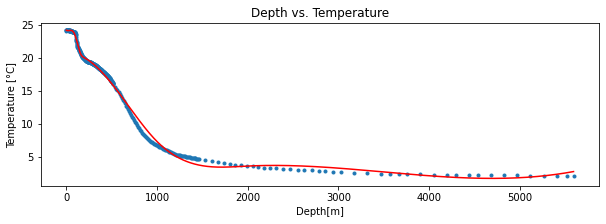

Max. depth = 5594.616 [m] # parameters: 10


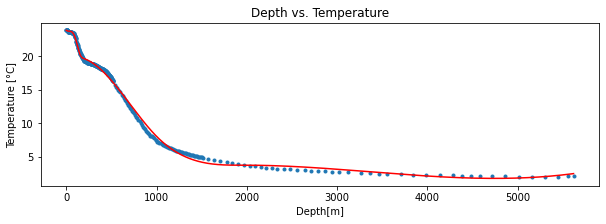

Max. depth = 5620.7554 [m] # parameters: 10


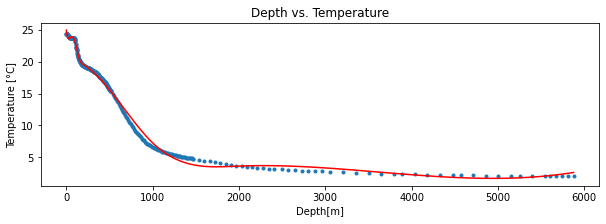

Max. depth = 5876.674 [m] # parameters: 10


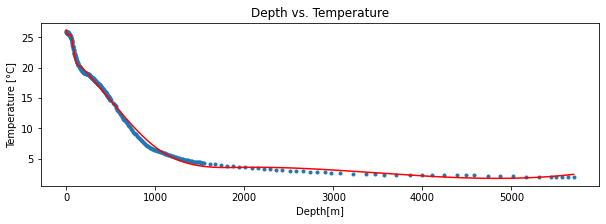

Max. depth = 5699.5796 [m] # parameters: 10


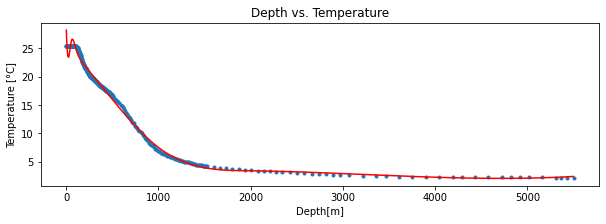

Max. depth = 5502.1885 [m] # parameters: 10


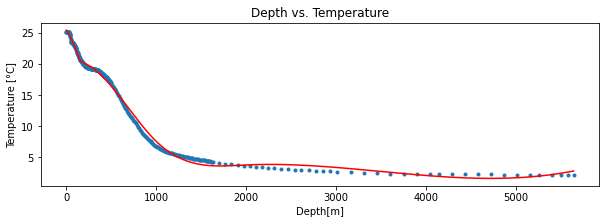

Max. depth = 5646.393 [m] # parameters: 10


In [9]:
# Find Argo profiles in vicinity
arr1, arr2 = np.where((depth > 4000) & (depth < 99999) & (T < 99999)) # arr1... row, arr2... column
arr1 = np.unique(arr1) # delete duplicate elements
depth_vicinity = np.array(depth[list(arr1),:])
T_vicinity = np.array(T[list(arr1),:])

# arr1, arr2 = np.where((depth > 4000) & (depth < 99999) & (PSAL < 99999)) # arr1... row, arr2... column
# arr1 = np.unique(arr1) # delete duplicate elements
# depth_vicinity = np.array(depth[list(arr1),:])
# T_vicinity = np.array(PSAL[list(arr1),:])

for i in range(10): #len(T_vicinity)
    depth_vic = depth_vicinity[i,:][depth_vicinity[i,:] < 8000]
    T_vic = T_vicinity[i,:][T_vicinity[i,:] < 50]
    
#     T_vic = T_vic[np.where(depth_vic > 2000)]
#     depth_vic = depth_vic[np.where(depth_vic > 2000)]
    
    #-----------------------------------------equidistant points
    # Approximation of Argo profiles in vicinity
    #dkappa_depth = ceil(np.max(depth_vic)/6) #ceil(np.max(depth_vic)/20)
    
    # nodes
    #kappa_x_depth = np.arange(np.min(depth_vic), ceil(np.max(depth_vic)/dkappa_depth)*dkappa_depth + dkappa_depth, dkappa_depth)
    #------------------------------------------
    
    #------------------------------------------distance depending on T/S gradient
    kappa_test = np.array((0, 50, 100, 150, 200, 1000, 2000, np.max(depth_vic)))
    dkappa_depth = 6000
    #------------------------------------------
    
    #A_vic = func.getA(kappa_x_depth, dkappa_depth, depth_vic)
    A_vic = func.getA(kappa_test, dkappa_depth, depth_vic)
    xS_vic,lS_vic,v_vic,rp_vic = func.linearGMM(A_vic, T_vic)
    
    t_raster_vic = np.arange(np.min(depth_vic), np.max(depth_vic), (np.max(depth_vic)-np.min(depth_vic))/10000)
    Ax_raster_vic = func.getA(kappa_test, dkappa_depth, t_raster_vic)
    f_raster_vic = Ax_raster_vic.dot(xS_vic)
    
    vic = plt.figure(figsize=(10,3))
    plt.plot(depth_vic, T_vic, '.')
    #plt.plot(depth_vic, lS_vic, 'r')
    plt.plot(t_raster_vic, f_raster_vic, 'r')
    plt.ylabel("Temperature [°C]")
    plt.xlabel("Depth[m]")
    plt.title('Depth vs. Temperature')
#     plt.ylabel("Salinity")
#     plt.title('Depth vs. Salinity')
    plt.show()
    #vic.savefig('vic_S'+str(i)+'.png', bbox_inches='tight')
    print("Max. depth =", np.max(depth_vic), "[m]", "# parameters:", len(xS_vic))

Compute misfits (of EN4 versus estimated functional) and visualize. Possible misfits criteria: RMS, Akaike Criterion

In [10]:
RMS_T = [round(x,2) for x in rms_T]
RMS_S = [round(x,2) for x in rms_S]
print(RMS_T)
print(RMS_S)

[0.82, 0.64, 1.17, 0.64, 0.87, 0.97, 0.37, 0.73, 0.77, 1.24, 0.43, 0.57, 0.21, 0.2]
[0.17, 0.12, 0.19, 0.12, 0.12, 0.12, 0.02, 0.01, 0.04, 0.06, 0.03, 0.02, 0.03, 0.03]


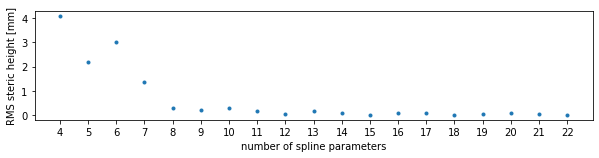

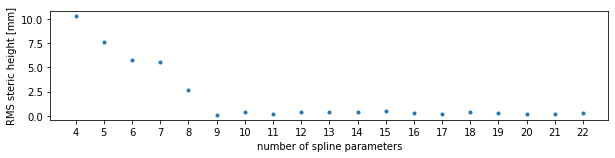

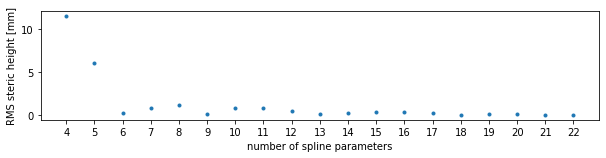

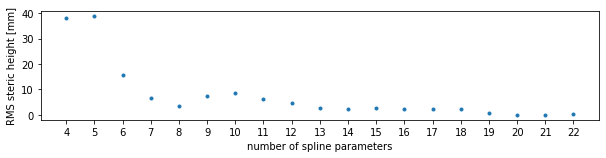

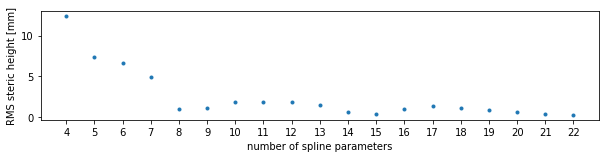

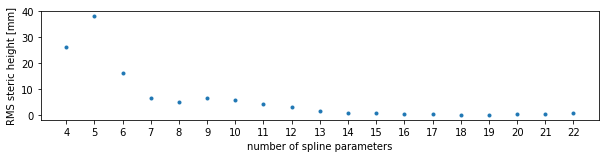

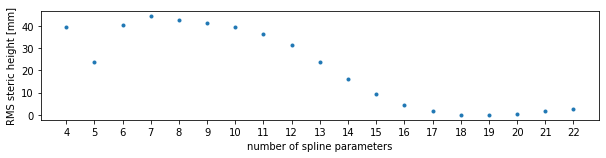

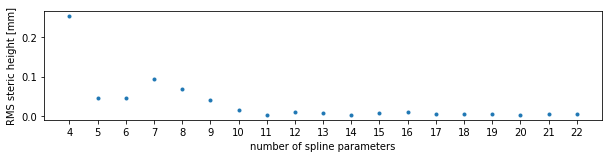

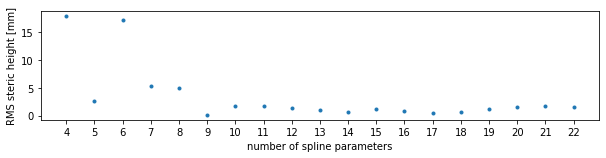

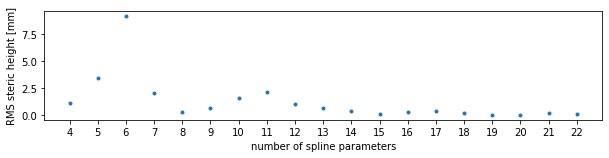

In [11]:
for i in range(10): #len(T)
    dh_prof = []
    dh_app = []
    numT = []
    numS = []
    for j in range(1,20):
        # (1) estimate a b-spline through the T,S data
        T_new = T[i,:][~T[i,:].mask]
        S_new = PSAL[i,:][~PSAL[i,:].mask]
        z = depth[i,:][~depth[i,:].mask]

        # adapt node distance to number of max depth
        dkappa_sp = ceil(np.max(z)/j) #ceil(np.max(depth_vic)/20)

        # nodes
        kappa_x_sp = np.arange(np.min(z), ceil(np.max(z)/dkappa_sp)*dkappa_sp + dkappa_sp, dkappa_sp)

        A_ = func.getA(kappa_x_sp, dkappa_sp, z)
        xS_T_sp,lS_T_sp,v_T_sp,rp_T = func.linearGMM(A_, T_new)
        xS_S_sp,lS_S_sp,v_S_sp,rp_S = func.linearGMM(A_, S_new) 
        numT.append(len(xS_T_sp))
        numS.append(len(xS_S_sp))

    #     plt.figure()
    #     plt.plot(z, T_new, 'b.')
    #     plt.plot(z, lS_T, 'r')
    #     plt.ylabel("Temperature [°C]")
    #     plt.xlabel("Depth[m]")
    #     plt.title('Depth vs. Temperature')
    #     plt.show()

    #     plt.figure()
    #     plt.plot(z, S_new, 'b.')
    #     plt.plot(z, lS_S, 'r')
    #     plt.xlabel("Depth[m]")
    #     plt.ylabel("Salinity")
    #     plt.title('Depth vs. Salinity')
    #     plt.show()

        # (2) compute the steric height change of the profile from the input data and approximated data.
        dh_prof.append(sth.TSz_to_h_steric2(T_new, S_new, -z, lat[i], long[i]))
        dh_app.append(sth.TSz_to_h_steric2(lS_T_sp, lS_S_sp, -z, lat[i], long[i]))

    # (3) This difference can be used as an overall metric (small is good), maybe plot them as a bunch of points dependent on the
    # number of spline parameters? (so Y axis RMS(sterheight_orig-sterheight_approx) , X axis number of spline parameters)
    diff = (np.asarray(dh_prof) - np.asarray(dh_app).T)[0]
    rms_sth = []
    for i in range(len(diff)):
        rms_sth.append(np.sqrt(np.mean(np.square(diff[i]))))
    rms_sth = np.asarray(rms_sth)    
    # print(diff)
    # print(rms_sth)
    # print(numT,numS)

    plt.figure(figsize=(10,2))
    plt.plot(numT, rms_sth*10**3, '.')
    plt.xlabel('number of spline parameters')
    plt.ylabel('RMS steric height [mm]')
    plt.xticks(numT)
    plt.show()

**Extrapolation**

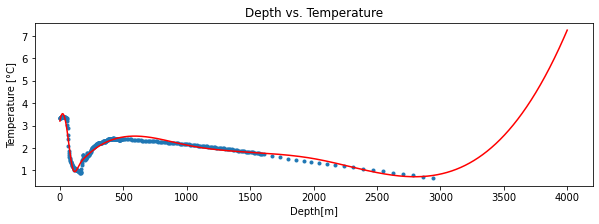

Max. depth = 2942.2998 [m] # parameters: 10


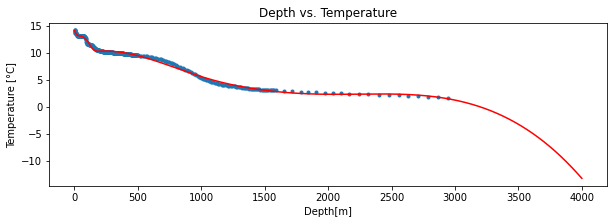

Max. depth = 2944.344 [m] # parameters: 10


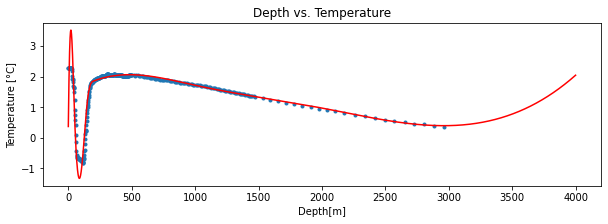

Max. depth = 2963.6492 [m] # parameters: 10


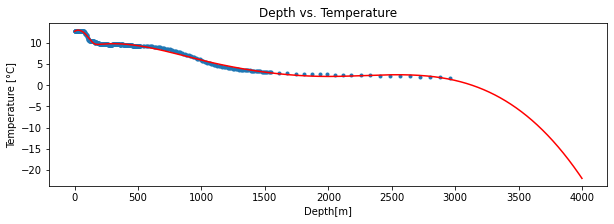

Max. depth = 2957.4224 [m] # parameters: 10


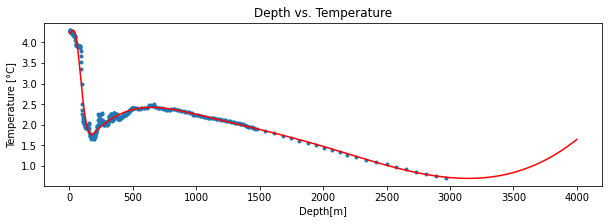

Max. depth = 2965.5022 [m] # parameters: 10


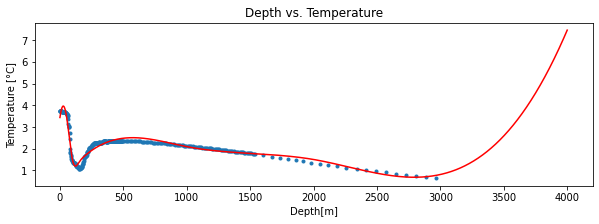

Max. depth = 2966.4368 [m] # parameters: 10


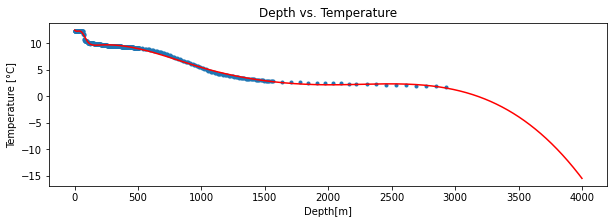

Max. depth = 2926.604 [m] # parameters: 10


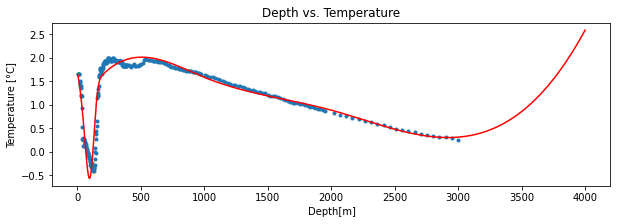

Max. depth = 2997.4836 [m] # parameters: 10


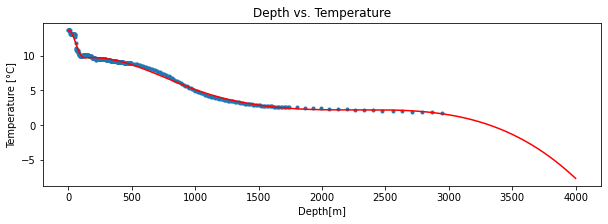

Max. depth = 2948.5576 [m] # parameters: 10


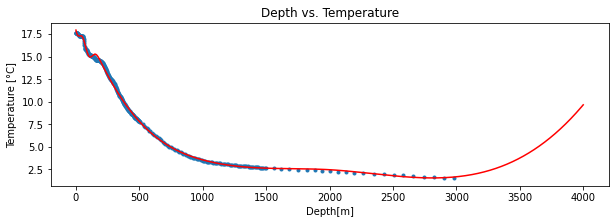

Max. depth = 2977.4497 [m] # parameters: 10


In [12]:
# Find Argo profiles in vicinity
arr1, arr2 = np.where((depth > 4000) & (depth < 99999) & (T < 99999)) # arr1... row, arr2... column
arr1 = np.unique(arr1) # delete duplicate elements
depth_vicinity = np.array(depth[list(arr1),:])
T_vicinity = np.array(T[list(arr1),:])

# arr1, arr2 = np.where((depth > 4000) & (depth < 99999) & (PSAL < 99999)) # arr1... row, arr2... column
# arr1 = np.unique(arr1) # delete duplicate elements
# depth_vicinity = np.array(depth[list(arr1),:])
# T_vicinity = np.array(PSAL[list(arr1),:])

for i in range(15,25): #len(T_vicinity)
    depth_vic = depth_vicinity[i,:][depth_vicinity[i,:] < 8000]
    T_vic = T_vicinity[i,:][T_vicinity[i,:] < 50]
    
    # cut off measurements
    T_vic = T_vic[np.where(depth_vic < 3000)]
    depth_vic = depth_vic[np.where(depth_vic < 3000)]
    #-----------------------------------------equidistant points
    # Approximation of Argo profiles in vicinity
    #dkappa_depth = ceil(np.max(depth_vic)/6) #ceil(np.max(depth_vic)/20)
    
    # nodes
    #kappa_x_depth = np.arange(np.min(depth_vic), ceil(np.max(depth_vic)/dkappa_depth)*dkappa_depth + dkappa_depth, dkappa_depth)
    #------------------------------------------
    
    #------------------------------------------distance depending on T/S gradient
    kappa_test = np.array((0, 50, 100, 150, 200, 1000, 2000, 4000)) #np.max(depth_vic)
    dkappa_depth = 6000
    #------------------------------------------
    
    #A_vic = func.getA(kappa_x_depth, dkappa_depth, depth_vic)
    A_vic = func.getA(kappa_test, dkappa_depth, depth_vic)
    xS_vic,lS_vic,v_vic,rp_vic = func.linearGMM(A_vic, T_vic)
    
    t_raster_vic = np.arange(np.min(depth_vic), 4000, (4000-np.min(depth_vic))/10000)
    Ax_raster_vic = func.getA(kappa_test, dkappa_depth, t_raster_vic)
    f_raster_vic = Ax_raster_vic.dot(xS_vic)
    
    vic = plt.figure(figsize=(10,3))
    plt.plot(depth_vic, T_vic, '.')
    #plt.plot(depth_vic, lS_vic, 'r')
    plt.plot(t_raster_vic, f_raster_vic, 'r')
    plt.ylabel("Temperature [°C]")
    plt.xlabel("Depth[m]")
    plt.title('Depth vs. Temperature')
#     plt.ylabel("Salinity")
#     plt.title('Depth vs. Salinity')
    plt.show()
    #vic.savefig('vic_S'+str(i)+'.png', bbox_inches='tight')
    print("Max. depth =", np.max(depth_vic), "[m]", "# parameters:", len(xS_vic))

/home/najona/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:138: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


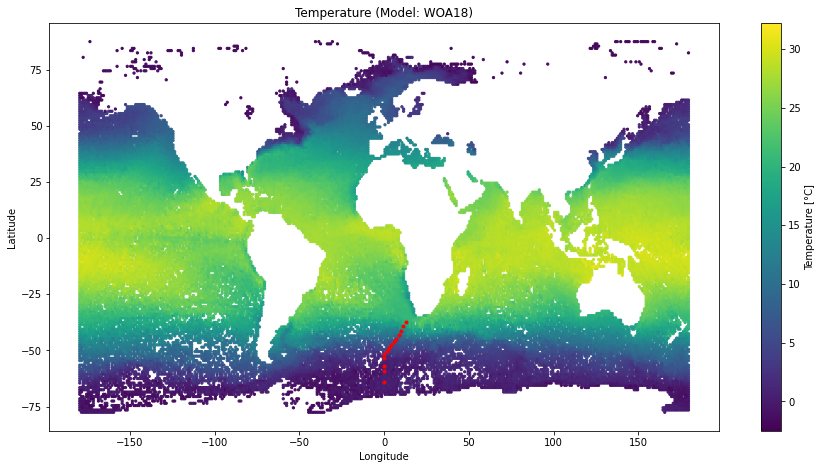

In [13]:
lo_m = []
la_m = []
T_m = []
for i in range(len(long_model)): 
    for j in range(lat_model.size): 
        lo_m.append(long_model[i])
        la_m.append(lat_model[j])
        T_m.append(t_mn[0,0,j,i])
    
marker_size=5
plt.figure(figsize=(15,7.5))
plt.scatter(lo_m, la_m, marker_size, c=T_m)
plt.plot(degE, degN, 'r.')
plt.title("Temperature (Model: WOA18)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
cbar= plt.colorbar()
cbar.set_label("Temperature [°C]")
plt.show()